In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/MCA KGEC/Minor Project/OG/CombinedData.csv")

# Drop Unnamed column
data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)

data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data = data.sample(n=6000,).reset_index(drop=True)
data

,statement,status
0,I have been hiding my depression &amp; anxiety...,Depression
1,I am still in shock. I am laying in our bed an...,Depression
2,jessdubb lmao u may have to wait for another s...,Normal
3,I'm 26. Tuesday is day one of therapy. Day one...,Stress
4,Are we neurodivergent? I was reading the post ...,Bipolar
...,...,...
5995,I am freaking out and I feel like I am in a cr...,Suicidal
5996,hey there everyone one of my biggest symptom h...,Depression
5997,m i had extreme anxiety depression year of my ...,Depression
5998,pharmaceutical vol page 9 depression and autoi...,Depression


## Preprocessing the data

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (only needed once)
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove special characters (punctuation, non-alphabetic characters)
    statement = re.sub(r'[^\w\s]', '', statement)

    # Remove numbers (optional, depending on your use case)
    statement = re.sub(r'\d+', '', statement)

    # Tokenize the statement (split into words)
    words = statement.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned statement
    cleaned_statement = ' '.join(words)

    return cleaned_statement

# Apply the cleaning function to the 'statement' column
data['statement'] = data['statement'].apply(clean_statement)

data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,statement,status
0,hiding depression amp anxiety friends amp fami...,Depression
1,still shock laying bed clothes cannot sleep fi...,Depression
2,jessdubb lmao u may wait another season come t...,Normal
3,im tuesday day one therapy day one trying talk...,Stress
4,neurodivergent reading post crapping coping me...,Bipolar
...,...,...
5995,freaking feel like crisis know way get support...,Suicidal
5996,hey everyone one biggest symptom ha extremely ...,Depression
5997,extreme anxiety depression year short life spe...,Depression
5998,pharmaceutical vol page depression autoimmune ...,Depression


In [ ]:
data['status'].value_counts()

,count
status,
Normal,1815
Depression,1729
Suicidal,1211
Anxiety,463
Bipolar,351
Stress,312
Personality disorder,119


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create an instance of RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Define features (X) and target (y)
X = data.drop(columns=['status'])
y = data['status']

# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the oversampled features and target back into a DataFrame
data = pd.concat([X_resampled, y_resampled], axis=1)

# Check the new class distribution
print(data['status'].value_counts())

status
Depression              1815
Normal                  1815
Stress                  1815
Bipolar                 1815
Suicidal                1815
Anxiety                 1815
Personality disorder    1815
Name: count, dtype: int64


In [ ]:
# Label encoding for 'status' column
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

## Train test splitting

In [ ]:
# Split data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size=0.2)
max([len(text) for text in data['statement']])

5590

## Tokenization

In [ ]:
# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Convert to Dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})

# Fine Tuning Bert

In [ ]:
# # Load model
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_)) # Changed 'label_encd' to 'label_encoder.classes_'
# # The following line contained a typo and is redundant, so it is removed.
# # BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encd))
# BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encd))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'label_encd' is not defined

In [ ]:
# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_)) # Corrected typo from 'label_encd' to 'label_encoder'
# The following line contained a typo and is redundant, so it is removed.
BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encd))
# Removed redundant line: BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encd))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# # Load model
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# # Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    evaluation_strategy="epoch",     # Evaluate once per epoch
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tuning the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    eval_strategy="epoch",     # Evaluate once per epoch - Changed from evaluation_strategy
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tuning the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nhidungare (nhidungare-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,1.080700,0.940969
2,0.324900,0.397221
3,0.303300,0.288854
4,0.179700,0.272535
5,0.131400,0.286178


TrainOutput(global_step=1590, training_loss=0.5622147910999802, metrics={'train_runtime': 2139.0527, 'train_samples_per_second': 23.758, 'train_steps_per_second': 0.743, 'total_flos': 5223400043400000.0, 'train_loss': 0.5622147910999802, 'epoch': 5.0})

In [ ]:
# d1d4560daac47ba58f9b957cf8cc280809077743

# Evaluating The model

                      precision    recall  f1-score   support

             Anxiety       0.98      0.99      0.98       378
             Bipolar       0.98      0.99      0.99       377
          Depression       0.76      0.72      0.74       358
              Normal       0.92      0.90      0.91       345
Personality disorder       0.99      1.00      0.99       363
              Stress       0.94      1.00      0.97       351
            Suicidal       0.78      0.77      0.78       369

            accuracy                           0.91      2541
           macro avg       0.91      0.91      0.91      2541
        weighted avg       0.91      0.91      0.91      2541



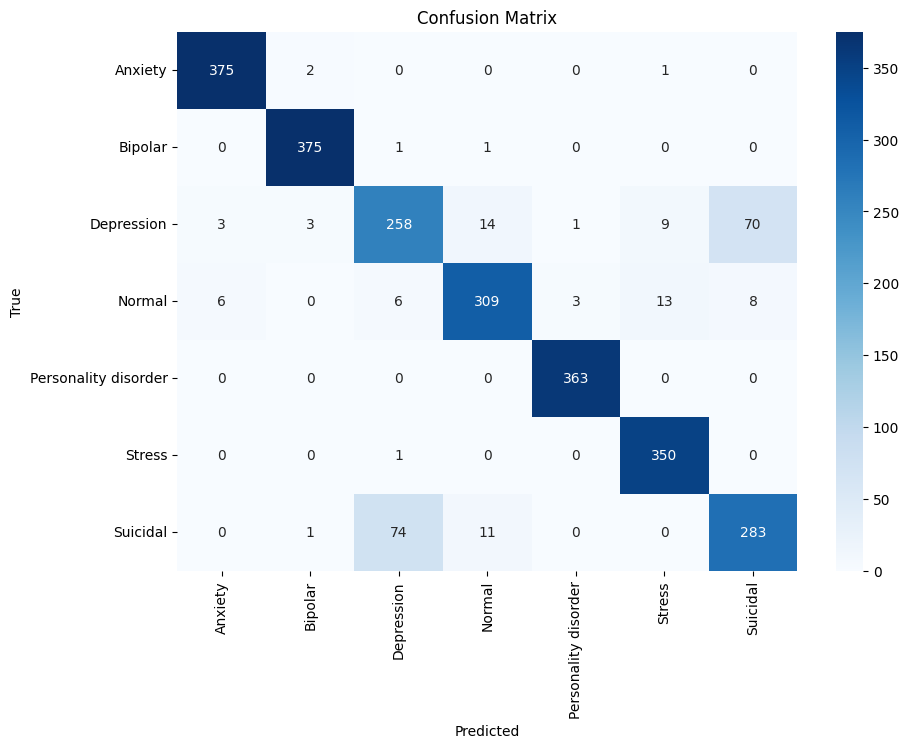

In [ ]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Saving and Loading the Model and Tokenizer

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# trainer.save_model('/content/drive/MyDrive/saved_mental_status_bert')
# tokenizer.save_pretrained('/content/drive/MyDrive/saved_mental_status_bert')

In [ ]:
# Save the trained model and tokenizer
# from google.colab import drive
# drive.mount('/content/drive')

trainer.save_model("saved_mental_status_bert")  # Save the model to the specified directory
tokenizer.save_pretrained("saved_mental_status_bert")  # Save the tokenizer


import pickle

pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_mental_status_bert")

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

# Testing the Detection System

In [ ]:
# Detection System (Example)
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test detection system with a mixture of normal, anxiety, bipolar, depression, suicide, etc.
sample_texts = [
    "I feel bad today, I am worried about it.",
    "I feel overwhelmed and anxious about my current situation, and I've noticed a significant drop in my mood and energy levels.",
    "I've been feeling quite down lately, and it seems like small things are affecting me more than usual.",
    "How has your overall well-being been lately, and are there any specific moments or events that have been affecting you?",
    "No significant changes in overall well-being, no specific moments or events affecting me.",
    "No significant changes in overall well-being, no specific moments or events affecting me.",
   "No significant changes in anxiety and stress levels lately, no specific triggers or events.",
  "No significant changes in overall well-being, no specific areas needing more attention.",
  "No significant changes in mental health progression since the last session, and no specific areas to focus on.",
  "I feel neutral about my current mental health journey, and I'm open to exploring more areas.",
  "No significant changes in overall well-being since the last session.",
  "I haven't noticed any significant changes in my overall feelings since our last session.",
"I feel a bit better than last time, but still not great.",
"I prefer not to discuss my workload and stress levels at the moment.",
"I've been feeling quite unwell since our last session.",
"I've been feeling quite well since our last session.",
"I feel a bit better than last time, but still not great.",
"I am feeling good about my overall well-being since our last session.",
"I've been feeling good overall since our last session.",
"Overall, I've been feeling a bit better since our last session.",
"Overall, I've been feeling quite well since our last session."

]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

In [ ]:
import torch

def detection(text):
  text=clean_statement(text)
  inputs=tokenizer(text,return_tensors='pt',padding=True,truncation=True,max_length=200)
  outputs=model(**inputs)
  logits=outputs.logits
  prediction_label=torch.argmax(logits,dim=1).item()
  return label_encoder.inverse_transform([prediction_label])[0]

text="I feel like ending my life"
print(detection(text))

In [ ]:
# Downlaoding Model
import shutil
from google.colab import files

# Step 1: Save the trained model and tokenizer
model_save_path = "saved_mental_status_bert"  # Path to save the trained model
tokenizer_save_path = "saved_mental_status_bert"  # Path to save the tokenizer

# Save the model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Step 2: Create a zip file containing the saved model and tokenizer using shutil
zip_file_path = "saved_mental_status_bert"  # Path for the zip file without extension

# Create a zip archive of the directories
shutil.make_archive(zip_file_path, 'zip', root_dir='saved_mental_status_bert', base_dir='')

# Step 3: Provide a download link to the zip file
files.download(f"{zip_file_path}.zip")
